In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [26]:
sales_total = pd.read_csv("/content/drive/MyDrive/Forecasting/FRED-LTOTALNSA.csv", index_col='Date', parse_dates=True)
sales = sales_total[6:]
sales_test = sales_total[:6]
sales

,Value
Date,
2021-07-01,1280.803
2021-06-01,1302.213
2021-05-01,1570.313
2021-04-01,1518.415
2021-03-01,1597.152
...,...
1976-05-01,1176.100
1976-04-01,1163.200
1976-03-01,1216.100


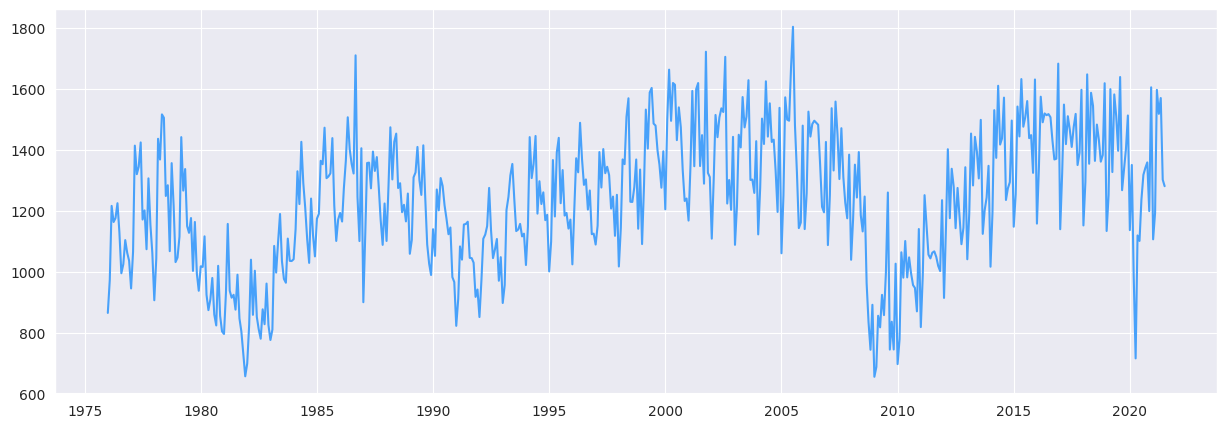

In [27]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(sales, c='#48A1FA')
plt.show()

**Checking For stationarity**

**Histogram plot**

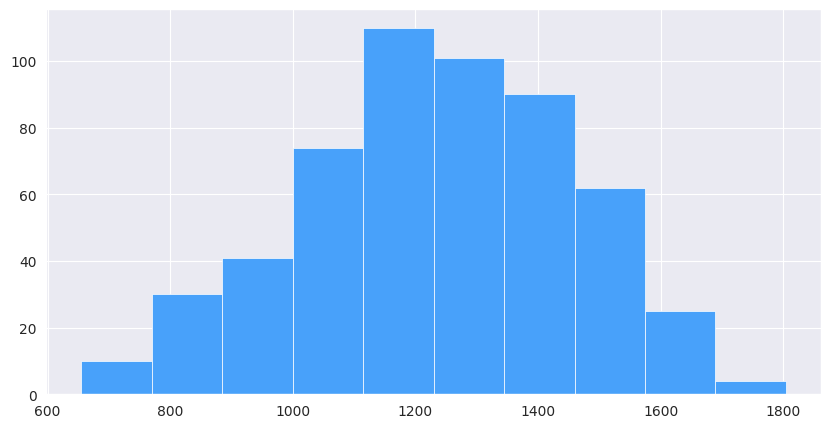

In [28]:
pd.Series(sales['Value']).hist(color="#48A1FA", figsize=(10,5));

**Checking Mean and Variance over small chunks**

In [30]:
sales_chunks = np.split(sales['Value'][:-7], 12)
means = np.round(np.mean(sales_chunks, axis=1), 2)
stds = np.round(np.std(sales_chunks, axis=1), 2)
chunks_df = pd.DataFrame({'chunks': list(range(1, len(sales_chunks)+1)), 'mean_values': means, 'variance_vals': stds})
chunks_df

,chunks,mean_values,variance_vals
0,1,1360.32,195.92
1,2,1432.96,132.36
2,3,1150.16,161.60
3,4,1108.27,257.10
4,5,1398.60,167.14
5,6,1432.12,149.44
6,7,1265.18,124.69
7,8,1142.47,141.14
8,9,1188.16,143.29
9,10,1271.03,143.01


**Augumented Dicket-Fuller test**

In [31]:
from statsmodels.tsa.stattools import adfuller
adf, pval, usedlag, nobs, critical_vals, icbest = adfuller(sales['Value'])

In [32]:
print('P value',pval)
print(adf)
print(icbest)
print(usedlag)
print(critical_vals)

P value 0.04930276721428697
-2.8671561463104314
6375.89291025585
17
{'1%': -3.442772146350605, '5%': -2.8670191055991836, '10%': -2.5696881663873414}


**Time series is non-stationary**

**KPSS test**

In [33]:
import pandas as pd
from statsmodels.tsa.stattools import kpss

# Perform the KPSS test
kpss_stat, p_value, lags, critical_values = kpss(sales['Value'])

print("KPSS Statistic:", kpss_stat)
print("p-value:", p_value)
print("Lags:", lags)
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")

KPSS Statistic: 0.8918923670343433
p-value: 0.01
Lags: 14
Critical Values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


**Time series is non-stationary**

In [34]:
import statsmodels.api as sm
from statsmodels.compat import lzip
const_array = np.ones_like(sales)

reg_model = sm.OLS(sales, const_array).fit()

# Calculate the residuals
residuals = reg_model.resid

bp_model = sm.OLS(residuals**2, const_array).fit()

# Perform the Breusch-Pagan test
bp_test = bp_model.get_robustcov_results(cov_type='HC1')
test_statistic = bp_test.bse[0]
p_value = bp_test.pvalues[0]

print("Breusch-Pagan Test Results:")
print("Test Statistic:", test_statistic)
print("p-value:", p_value)

Breusch-Pagan Test Results:
Test Statistic: 2583.260570859553
p-value: 2.218187457805557e-60


**The time series is non-stationary and there is a high chance of Heteroscedasticity**

**Decomposition of time series into Trend, Seasonal, and Residuals components**

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(x=sales, model = 'additive', period=12)
trend = ss_decomposition.trend
seasonal = ss_decomposition.seasonal
residual = ss_decomposition.resid

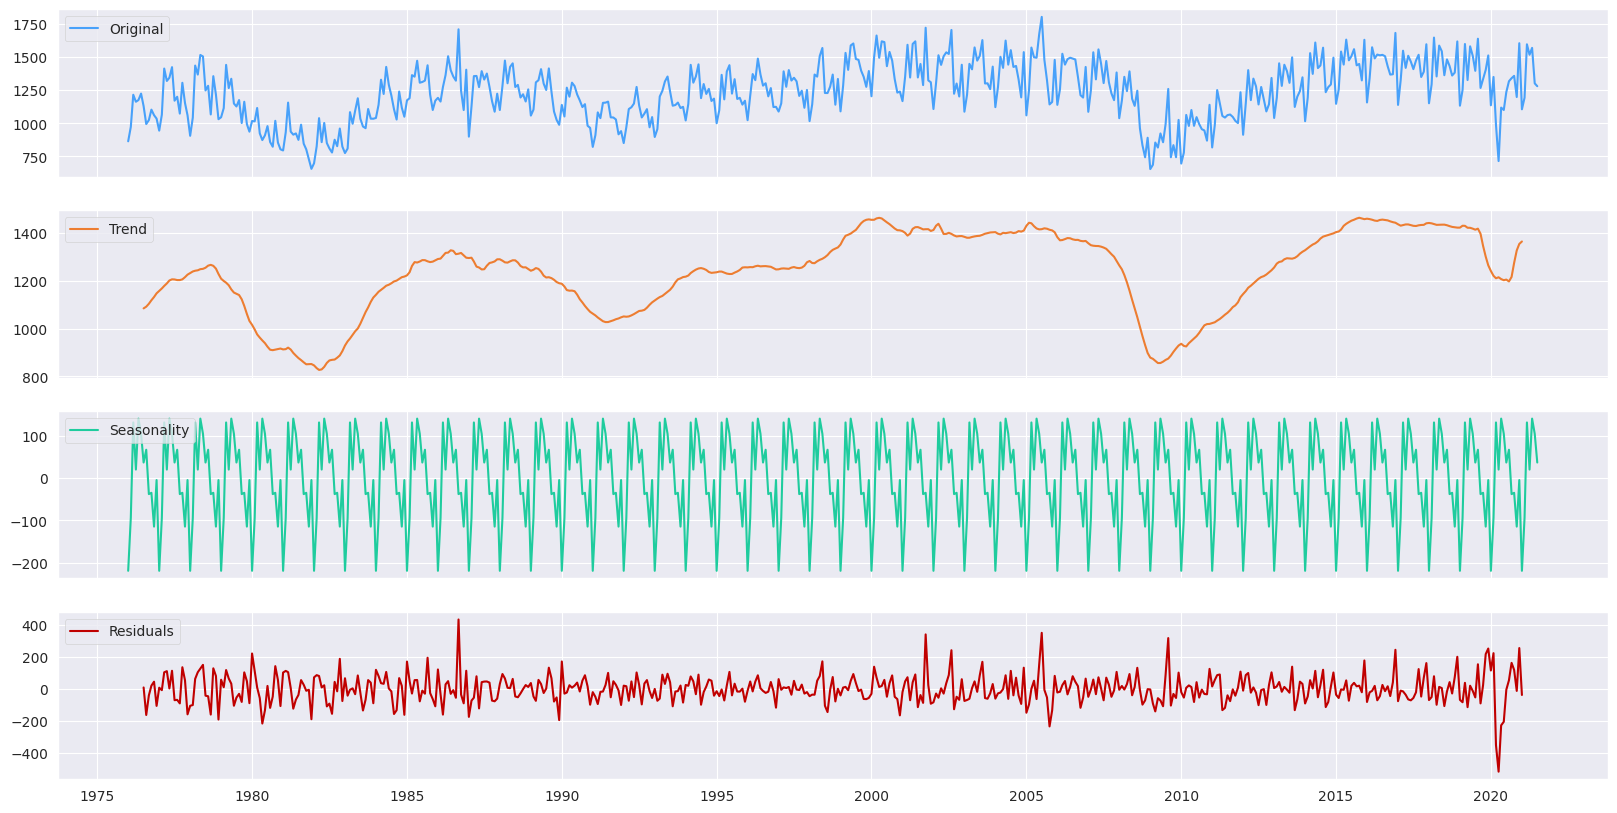

In [36]:
sns.set_style("darkgrid")
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(20,10))

axes[0].plot(sales.Value, label='Original', c="#48A1FA")
axes[0].legend(loc='upper left');

axes[1].plot(trend, label='Trend', c="#ED7D31")
axes[1].legend(loc='upper left');

axes[2].plot(seasonal, label='Seasonality', c="#1FCC9E")
axes[2].legend(loc='upper left');

axes[3].plot(residual, label='Residuals', c="#C00000")
axes[3].legend(loc='upper left');

**Rollin mean and standar deviation plots**

In [37]:
# define Dickey-Fuller Test (DFT) function
# Null is that unit root is present, rejection means likely stationary
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(18, 7))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic           -2.867156
p-value                   0.049303
Lags Used                17.000000
Observations Used       529.000000
Critical Value (1%)      -3.442772
Critical Value (5%)      -2.867019
Critical Value (10%)     -2.569688
dtype: float64


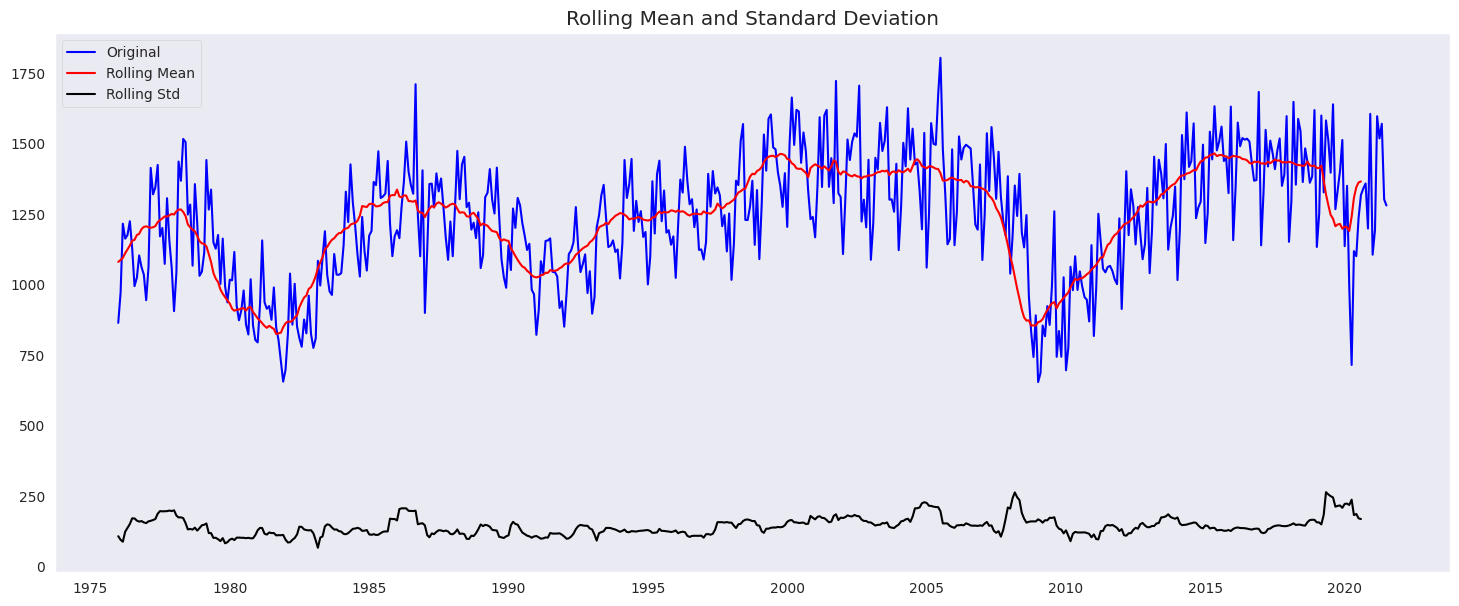

In [38]:
dftest(sales['Value'])

**Making Time Series statioanry by making necessary transformations**

In [39]:
sales['difference'] = sales['Value'].diff(12)

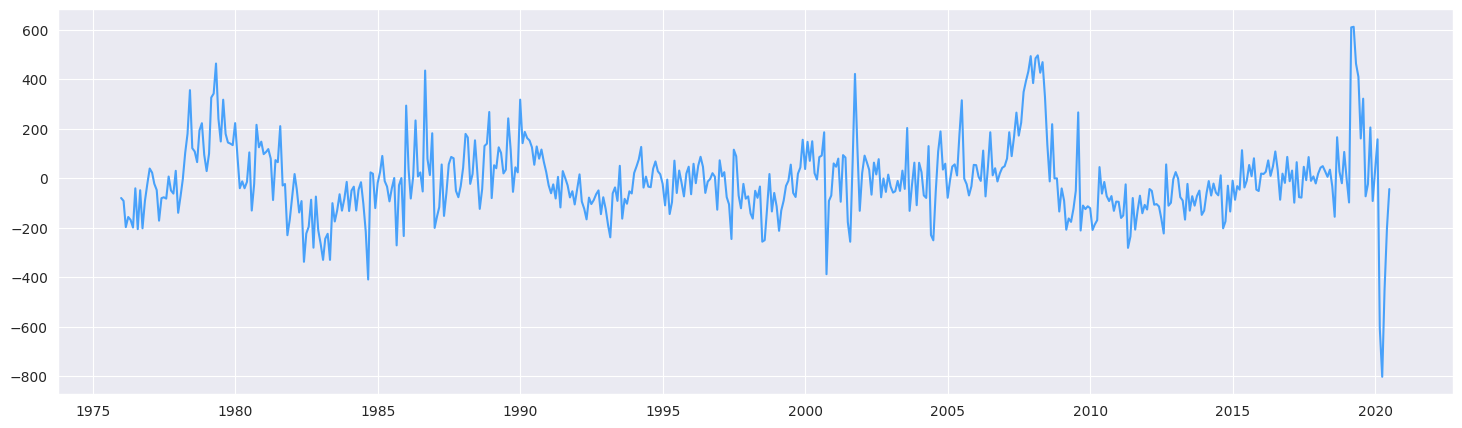

In [40]:
fig, ax = plt.subplots(figsize=(18,5))
ax.plot(sales.difference, c='#48A1FA')
plt.show()

**Making all the values positive to apply log transformation**`

In [41]:
print(min(sales[12:].difference))

-803.093


In [43]:
sales['difference_positive'] = sales['difference'] + 810

In [44]:
sales['log_transformed'] = np.log(sales.difference_positive)

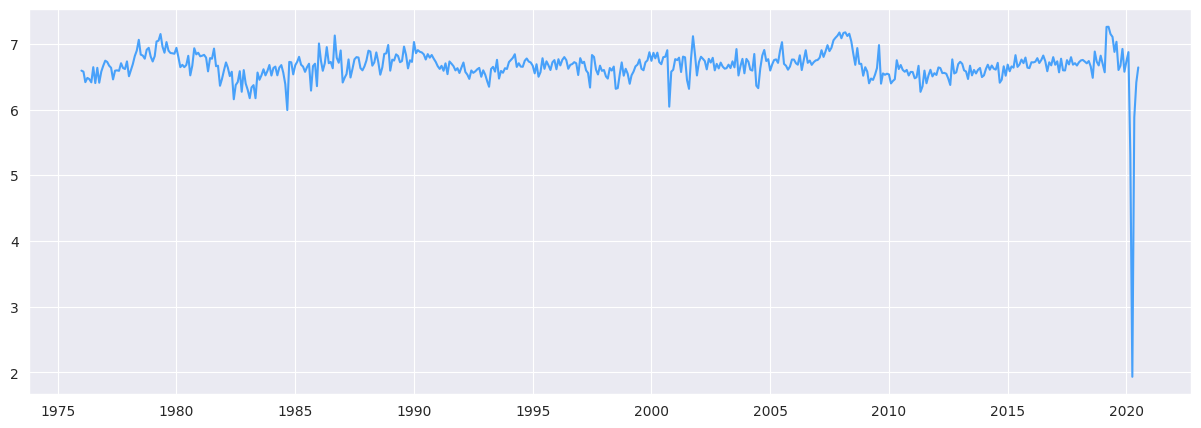

In [45]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(sales.log_transformed, c='#48A1FA')
plt.show()

**Now it looks like stationary, let's confirm with ADF, KPSS and Breusch-Pagan Tests**

**ADF test**

In [46]:
adf1, pval1, usedlag1, nobs1, critical_vals1, icbest1 = adfuller(sales['log_transformed'][12:])
print('P value',pval1)
print(adf1)
print(icbest1)
print(usedlag1)
print(critical_vals1)

P value 0.0020399784062150213
-3.8993035732222285
-649.8638588989804
13
{'1%': -3.4429638415440995, '5%': -2.867103482127635, '10%': -2.569733131582922}


**KPSS test**

In [47]:
# Perform the KPSS test
kpss_stat1, p_value1, lags1, critical_values1 = kpss(sales['log_transformed'][12:])

# Print the test results
print("KPSS Statistic:", kpss_stat1)
print("p-value:", p_value1)
print("Lags:", lags1)
print("Critical Values:")
for key, value in critical_values1.items():
    print(f"  {key}: {value}")

KPSS Statistic: 0.08838185811073265
p-value: 0.1
Lags: 11
Critical Values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [48]:
const_array1 = np.ones_like(sales.log_transformed[12:])
reg_model1 = sm.OLS(sales.log_transformed[12:], const_array1).fit()

# Calculate the residuals
residuals1 = reg_model1.resid

bp_model1 = sm.OLS(residuals1**2, const_array1).fit()

# Perform the Breusch-Pagan test
bp_test1 = bp_model1.get_robustcov_results(cov_type='HC1')
test_statistic1 = bp_test1.bse[0]
p_value1 = bp_test1.pvalues[0]

# Print the test results
print("Breusch-Pagan Test Results:")
print("Test Statistic:", test_statistic1)
print("p-value:", p_value1)

Breusch-Pagan Test Results:
Test Statistic: 0.04202001606332049
p-value: 0.06858923860505033


In [50]:
from tabulate import tabulate

adf_pvalue = 0.0020399784062150213
kpss_pvalue = 0.1
bp_pvalue = 0.06858923860505033

data = [
    ['ADF Test', adf_pvalue],
    ['KPSS Test', kpss_pvalue],
    ['Breusch-Pagan Test', bp_pvalue]
]

print(tabulate(data, headers=['Test', 'p-value'], tablefmt='fancy_grid'))


╒════════════════════╤════════════╕
│ Test               │    p-value │
╞════════════════════╪════════════╡
│ ADF Test           │ 0.00203998 │
├────────────────────┼────────────┤
│ KPSS Test          │ 0.1        │
├────────────────────┼────────────┤
│ Breusch-Pagan Test │ 0.0685892  │
╘════════════════════╧════════════╛


**All tests say that Time series is stationary**

**Decomposing the transformed time series**

In [51]:
ss_decomposition1 = seasonal_decompose(x=sales.log_transformed[12:], model = 'additive', period=12)
trend1 = ss_decomposition1.trend
seasonal1 = ss_decomposition1.seasonal
residual1 = ss_decomposition1.resid

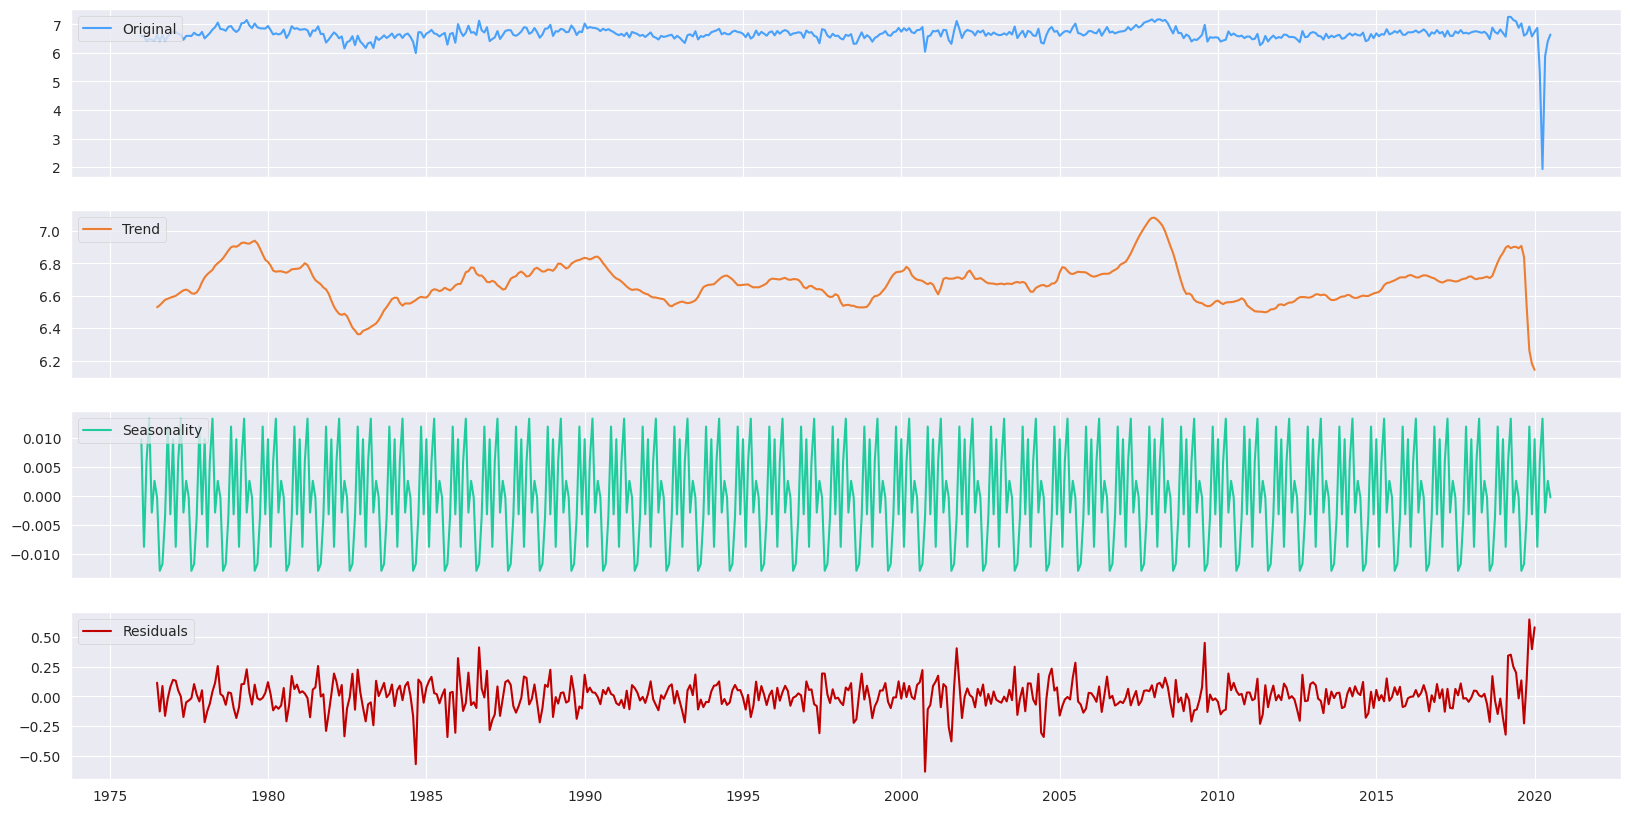

In [52]:
sns.set_style("darkgrid")
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(20,10))

axes[0].plot(sales.log_transformed[12:], label='Original', c="#48A1FA")
axes[0].legend(loc='upper left');

axes[1].plot(trend1, label='Trend', c="#ED7D31")
axes[1].legend(loc='upper left');

axes[2].plot(seasonal1, label='Seasonality', c="#1FCC9E")
axes[2].legend(loc='upper left');

axes[3].plot(residual1, label='Residuals', c="#C00000")
axes[3].legend(loc='upper left');

**ACF and PACF plots**

In [53]:
from statsmodels.graphics.tsaplots import acf, plot_acf

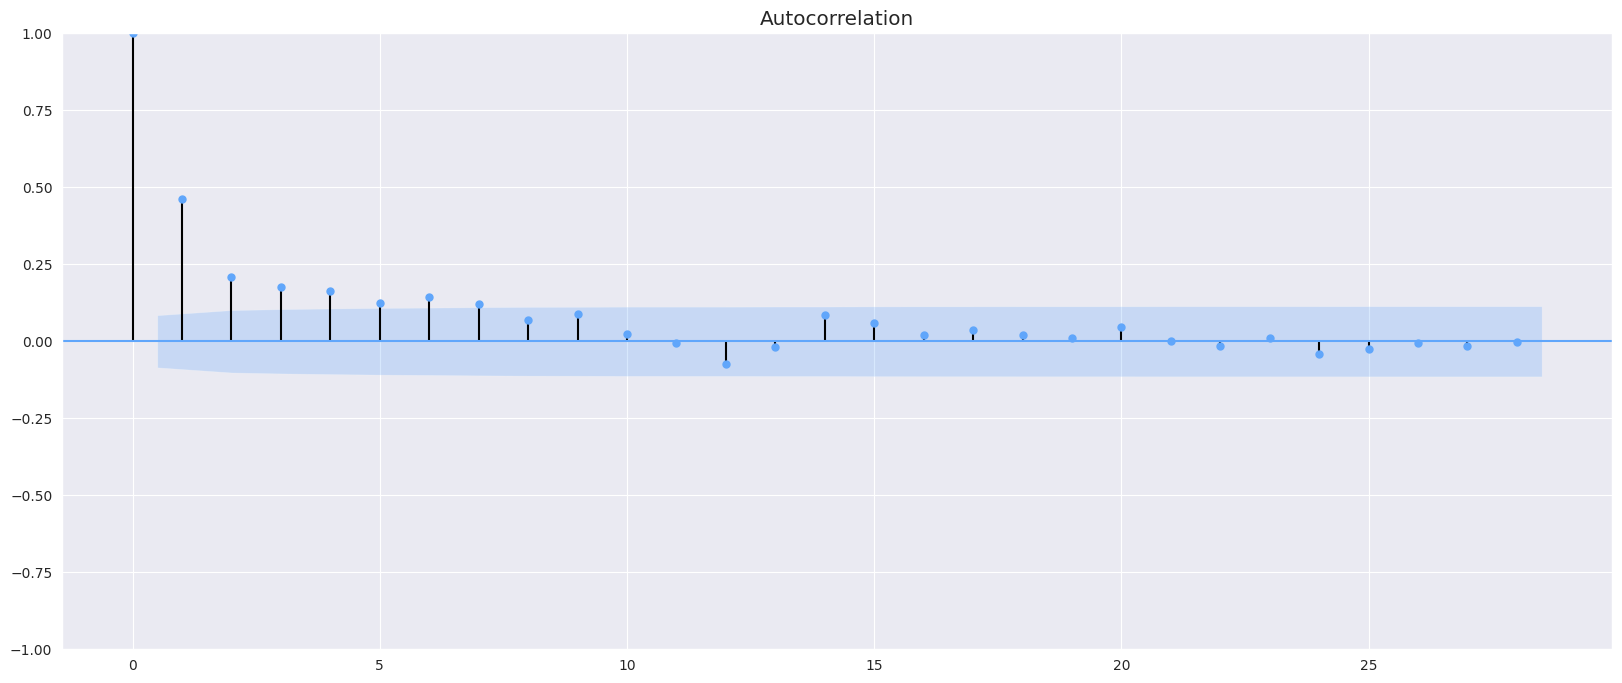

In [54]:
from matplotlib.collections import PolyCollection
fig, ax = plt.subplots(figsize=(20,8))
plot_acf(sales.log_transformed[12:], ax=ax,
         color='#60A6FB',
         vlines_kwargs={"colors": '#000000'})

for item in ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor('#60A6FB')

plt.show()

In [55]:
from statsmodels.graphics.tsaplots import pacf, plot_pacf

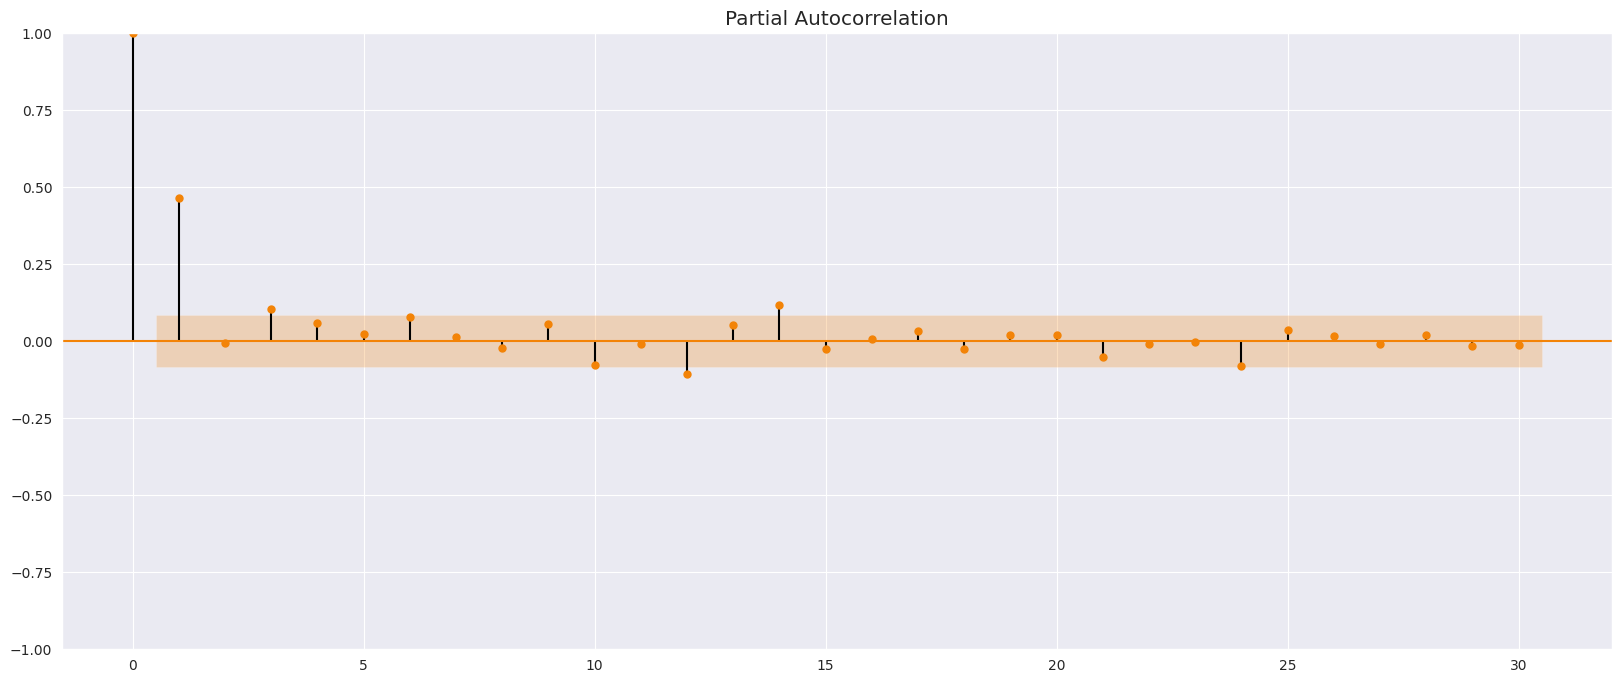

In [56]:
fig, ax = plt.subplots(figsize=(20,8))

plot_pacf(sales.log_transformed[12:],
          lags=30, ax=ax, color='#F38307',
          vlines_kwargs={"colors": '#000000'})

for item in ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor('#F38307')

plt.show()

**Based on this plots AR = 1, MA = 4**

**Let's fit ARMA model with the help of ACF and PACF plots**

In [88]:
ARMA = sm.tsa.statespace.SARIMAX(sales.log_transformed,
                                order=(1,0,4),
                                seasonal_order=(0,0,0,12),
                                trend='c').fit()
ARMA.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency -1MS will be used.
  
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency -1MS will be used.
  
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  if isinstance(retvals, dict):


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        log_transformed   No. Observations:                  547
Model:               SARIMAX(1, 0, 4)   Log Likelihood                   3.549
Date:                Fri, 16 Jun 2023   AIC                              6.902
Time:                        19:18:23   BIC                             37.033
Sample:                             0   HQIC                            18.679
                                - 547                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1526      0.187      6.153      0.000       0.785       1.520
ar.L1          0.8265      0.029     28.970      0.000       0.771       0.882
ma.L1         -0.4397      0.031    -14.071      0.000      -0.501      -0.378
ma.L2         -0.2845      0.029     -9.900      0.000      -0.341      -0.228
ma.L3         -0.0320      0.043     -0.748      0.455      -0.116       0.052
ma.L4          0.4058      0.019     21.496      0.000       0.369       0.443
sigma2         0.0579      0.001     69.319      0.000       0.056       0.060
===================================================================================
Ljung-Box (L1) (Q):                   2.16   Jarque-Bera (JB):            492409.89
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                            -8.03
Prob(H) (two-sided):                  0.00   Kurtosis:                       149.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
!pip install git+https://github.com/statsmodels/statsmodels.git
!pip install pmdarima
import pmdarima as pm
#!pip install pmdarima-1.7.1-cp37-cp37m-win_amd64.whl
#from pyramid.arima import auto_arima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/statsmodels/statsmodels.git to /tmp/pip-req-build-ah3bsefz
  Running command git clone --filter=blob:none --quiet https://github.com/statsmodels/statsmodels.git /tmp/pip-req-build-ah3bsefz
  Resolved https://github.com/statsmodels/statsmodels.git to commit 803b841d2dbf6d6b463523c5a75bc87aa82f25bf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for statsmodels: filename=statsmodels-0.15.0.dev24+g803b841d2-cp310-cp310-linux_x86_64.whl size=23240888 sha256=9148d3c723c23e977822d1b55b98a98c98fbe6de1b0b232678ddf68625233744
  Stored in directory: /tmp/pip-ephem-wheel-cache-g61651uo/wheels/63/99/aa/bb07110a6e10e2d86fabb8c067f39ed97d662d486bb01ca22b
Successfully built statsmodels
  Attempting uninstall: statsmodels
    Found 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.1 MB/s eta 0:00:00


**Let's use Auto ARIMA to select the best parameters**

In [66]:
'''import pmdarima as pm
from pmdarima.model_selection import train_test_split

# Split the data into training and testing sets
train_data = sales['log_transformed'][12:]

# Define the parameter ranges for grid search
p_range = range(0, 5)  # Autoregressive order
d_range = range(0, 2)  # Differencing order
q_range = range(0, 3)  # Moving average order
P_range = range(0, 3)  # Seasonal autoregressive order
D_range = range(0, 2)  # Seasonal differencing order
Q_range = range(0, 4)  # Seasonal moving average order
s = 12  # Seasonal period

# Perform grid search to find the best parameters
model = pm.auto_arima(train_data, start_p=1, start_q=1, max_p=5, max_q=5,
                      start_P=0, start_D=0, start_Q=0, max_P=5, max_D=5, max_Q=5,
                      seasonal=True, m=s, stepwise=True, suppress_warnings=True)

# Get the best model parameters
best_order = model.order
best_seasonal_order = model.seasonal_order

print("Best SARIMA order:", best_order)
print("Best seasonal order:", best_seasonal_order)'''

'import pmdarima as pm\nfrom pmdarima.model_selection import train_test_split\n\n# Split the data into training and testing sets\ntrain_data = sales[\'log_transformed\'][12:]\n\n# Define the parameter ranges for grid search\np_range = range(0, 5)  # Autoregressive order\nd_range = range(0, 2)  # Differencing order\nq_range = range(0, 3)  # Moving average order\nP_range = range(0, 3)  # Seasonal autoregressive order\nD_range = range(0, 2)  # Seasonal differencing order\nQ_range = range(0, 4)  # Seasonal moving average order\ns = 12  # Seasonal period\n\n# Perform grid search to find the best parameters\nmodel = pm.auto_arima(train_data, start_p=1, start_q=1, max_p=5, max_q=5,\n                      start_P=0, start_D=0, start_Q=0, max_P=5, max_D=5, max_Q=5,\n                      seasonal=True, m=s, stepwise=True, suppress_warnings=True)\n\n# Get the best model parameters\nbest_order = model.order\nbest_seasonal_order = model.seasonal_order\n\nprint("Best SARIMA order:", best_order)\npr

In [64]:
stepwise_model = pm.auto_arima(sales.log_transformed[12:], start_p=1, start_q=1,
                           max_p=6, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-18.851, Time=5.12 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=148.311, Time=0.18 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=4.13 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=24.658, Time=1.32 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3550.874, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=23.365, Time=1.06 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=6.96 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=-23.375, Time=10.02 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=236.586, Time=9.91 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=3.441, Time=2.49 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=-24.799, Time=4.43 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-11.445, Time=1.76 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=117.889, Time=9.64 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=3.54 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=inf,

In [129]:
SARIMA = sm.tsa.statespace.SARIMAX(sales.log_transformed,
                                order=(1,0,0),
                                seasonal_order=(0,0,2,12),
                                trend='c').fit()
SARIMA.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency -1MS will be used.
  
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency -1MS will be used.
  
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                         log_transformed   No. Observations:                  547
Model:             SARIMAX(1, 0, 0)x(0, 0, [1, 2], 12)   Log Likelihood                  17.400
Date:                                 Fri, 16 Jun 2023   AIC                            -24.799
Time:                                         19:54:32   BIC                             -3.277
Sample:                                              0   HQIC                           -16.387
                                                 - 547                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4659      0.101     34.211      0.000       3.267       3.664
ar.L1          0.4806      0.015     31.577      0.000       0.451       0.510
ma.S.L12      -0.5339      0.033    -16.242      0.000      -0.598      -0.469
ma.S.L24      -0.2919      0.021    -13.714      0.000      -0.334      -0.250
sigma2         0.0537      0.001     36.353      0.000       0.051       0.057
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            372550.45
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                            -8.02
Prob(H) (two-sided):                  0.00   Kurtosis:                       129.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 547 entries, 2021-07-01 to 1976-01-01
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Value                547 non-null    float64
 1   difference           535 non-null    float64
 2   difference_positive  535 non-null    float64
 3   log_transformed      535 non-null    float64
dtypes: float64(4)
memory usage: 21.4 KB


In [74]:
sales['log_transformed'].head(13)

Date
2021-07-01         NaN
2021-06-01         NaN
2021-05-01         NaN
2021-04-01         NaN
2021-03-01         NaN
2021-02-01         NaN
2021-01-01         NaN
2020-12-01         NaN
2020-11-01         NaN
2020-10-01         NaN
2020-09-01         NaN
2020-08-01         NaN
2020-07-01    6.640973
Name: log_transformed, dtype: float64

In [75]:
sales['log_transformed'].tail(13)

Date
1977-01-01    6.743824
1976-12-01    6.665556
1976-11-01    6.576330
1976-10-01    6.408858
1976-09-01    6.634765
1976-08-01    6.403077
1976-07-01    6.644831
1976-06-01    6.414114
1976-05-01    6.463653
1976-04-01    6.481424
1976-03-01    6.416896
1976-02-01    6.576330
1976-01-01    6.592496
Name: log_transformed, dtype: float64

# **Forecasting**

# **ARMA**

In [91]:
sales['temp_forecast_ARMA'] = ARMA.predict(start = 0, end= sales.shape[0]-1)

In [92]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 547 entries, 2021-07-01 to 1976-01-01
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Value                    547 non-null    float64
 1   difference               535 non-null    float64
 2   difference_positive      535 non-null    float64
 3   log_transformed          535 non-null    float64
 4   temp_forecast_ARMA       547 non-null    float64
 5   temp_forecast_ARMA_expo  0 non-null      float64
 6   temp_forecast_ARMA_sub   0 non-null      float64
 7   Forecast_ARMA            0 non-null      float64
dtypes: float64(8)
memory usage: 54.6 KB


**Undoing the time series transformation**

In [93]:
sales['temp_forecast_ARMA_expo'] = np.exp(sales['temp_forecast_ARMA'])

In [94]:
sales['temp_forecast_ARMA_sub'] = sales['temp_forecast_ARMA_expo'] - 810

In [95]:
sales['Forecast_ARMA'] = sales['temp_forecast_ARMA_sub'].shift(12) + sales['Value'].shift(12)

In [96]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 547 entries, 2021-07-01 to 1976-01-01
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Value                    547 non-null    float64
 1   difference               535 non-null    float64
 2   difference_positive      535 non-null    float64
 3   log_transformed          535 non-null    float64
 4   temp_forecast_ARMA       547 non-null    float64
 5   temp_forecast_ARMA_expo  547 non-null    float64
 6   temp_forecast_ARMA_sub   547 non-null    float64
 7   Forecast_ARMA            535 non-null    float64
dtypes: float64(8)
memory usage: 54.6 KB


In [ ]:
#energy['tem_forecast_5'] = energy['tem_forecast_3'].shift(12) + energy['seasonal_difference']

**Forecasting on training data**

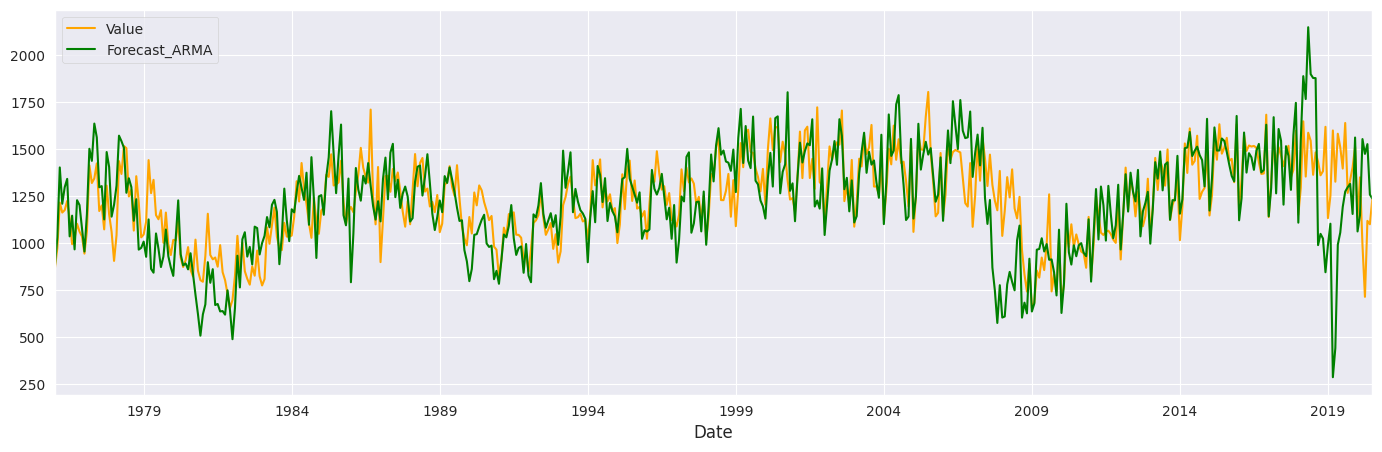

In [105]:
pd.plotting.register_matplotlib_converters()
sales[12:][['Value', 'Forecast_ARMA']].plot(color = ('orange','g'), figsize = (17,5));

**Evaluating ARMA model**

In [109]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(sales['Value'][12:], sales['Forecast_ARMA'][12:])
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 188.3732360843118


In [110]:
from sklearn.metrics import mean_absolute_percentage_error

# Drop rows with null values
#sales = sales.dropna()

# Calculate MAPE
mape = mean_absolute_percentage_error(sales['Value'][12:], sales['Forecast_ARMA'][12:]) * 100
print("MAPE:", mape)

MAPE: 10.768641269392488


In [111]:
from sklearn.preprocessing import MinMaxScaler

# Drop rows with null values
#sales = sales.dropna()

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(sales[['Value', 'Forecast_ARMA']])
sales['Value_scaled'] = scaled_sales[:, 0]
sales['Forecast_scaled'] = scaled_sales[:, 1]

# Calculate RMSE on scaled data
mse = mean_squared_error(sales['Value_scaled'][12:], sales['Forecast_scaled'][12:])
rmse = np.sqrt(mse)

print("RMSE:", rmse)

RMSE: 0.1323284325365477


In [146]:
from tabulate import tabulate
mape = 10.768641269392488
rmse = 188.3732360843118
rmse_minmax = 0.1323284325365477

table = [
    ["MAPE", mape],
    ["RMSE", rmse],
    ["RMSE (MinMax Scaled)", rmse_minmax]
]
headers = ["Metric", "Value"]
table_str = tabulate(table, headers, tablefmt="fancy_grid")
print(table_str)


╒══════════════════════╤════════════╕
│ Metric               │      Value │
╞══════════════════════╪════════════╡
│ MAPE                 │  10.7686   │
├──────────────────────┼────────────┤
│ RMSE                 │ 188.373    │
├──────────────────────┼────────────┤
│ RMSE (MinMax Scaled) │   0.132328 │
╘══════════════════════╧════════════╛


# **SARIMA**

In [136]:
sales['temp_forecast_SARIMA'] = SARIMA.predict(start = 0, end= sales.shape[0]-1)

In [137]:
sales['temp_forecast_SARIMA_expo'] = np.exp(sales['temp_forecast_SARIMA'])

In [138]:
sales['temp_forecast_SARIMA_sub'] = sales['temp_forecast_SARIMA_expo'] - 810

In [139]:
sales['Forecast_SARIMA'] = sales['temp_forecast_SARIMA_sub'].shift(12) + sales['Value'].shift(12)

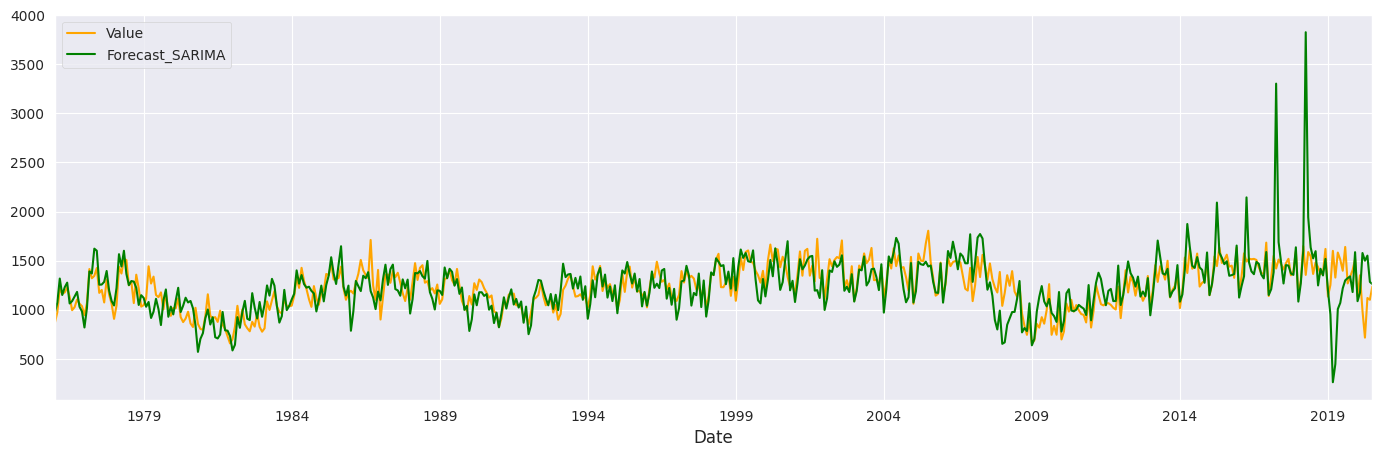

In [140]:
pd.plotting.register_matplotlib_converters()
sales[12:][['Value', 'Forecast_SARIMA']].plot(color = ('orange','g'), figsize = (17,5));

**Evaluating SARIMA model**

In [143]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse1 = mean_squared_error(sales['Value'][12:], sales['Forecast_SARIMA'][12:])
rmse1 = np.sqrt(mse1)
print("RMSE:", rmse1)

RMSE: 219.64367538983373


In [144]:
from sklearn.metrics import mean_absolute_percentage_error

# Drop rows with null values
#sales = sales.dropna()

# Calculate MAPE
mape1 = mean_absolute_percentage_error(sales['Value'][12:], sales['Forecast_SARIMA'][12:]) * 100
print("MAPE:", mape1)

MAPE: 10.581359467493646


In [145]:
from sklearn.preprocessing import MinMaxScaler

# Drop rows with null values
#sales = sales.dropna()

# Scale the data using MinMaxScaler
scaler1 = MinMaxScaler()
scaled_sales1 = scaler1.fit_transform(sales[['Value', 'Forecast_SARIMA']])
sales['Value_scaled'] = scaled_sales1[:, 0]
sales['Forecast_scaled'] = scaled_sales1[:, 1]

# Calculate RMSE on scaled data
mse2 = mean_squared_error(sales['Value_scaled'][12:], sales['Forecast_scaled'][12:])
rmse2 = np.sqrt(mse2)

print("RMSE:", rmse2)

RMSE: 0.2752738541003308


In [147]:
from tabulate import tabulate
mape = 10.581359467493646
rmse = 219.64367538983373
rmse_minmax = 0.2752738541003308

table = [
    ["MAPE", mape],
    ["RMSE", rmse],
    ["RMSE (MinMax Scaled)", rmse_minmax]
]
headers = ["Metric", "Value"]
table_str = tabulate(table, headers, tablefmt="fancy_grid")
print(table_str)


╒══════════════════════╤════════════╕
│ Metric               │      Value │
╞══════════════════════╪════════════╡
│ MAPE                 │  10.5814   │
├──────────────────────┼────────────┤
│ RMSE                 │ 219.644    │
├──────────────────────┼────────────┤
│ RMSE (MinMax Scaled) │   0.275274 │
╘══════════════════════╧════════════╛
